# Organize code for model comparison and validation!

I wanted to show you how I organize my code to compare and validate different machine
learning models

I'll explain this using the example of Linear Regression. The dataset that we're going
to be using is called the __mpg__ dataset.

It's generally a good practice to have all your imports at the top of your notebook.
This helps people who're looking at your notebook to easily understand all the packages
you'll be needing to run the notebook.

In [26]:
import typing
from functools import partial
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from typing_extensions import Protocol

import numpy as np
import plotnine as pn
import pandas as pd

from sklearn.linear_model.base import LinearModel

from plotnine.data import mpg
%matplotlib inline

We will be using a toy dataset – automobile_mpg to follow along. The mpg dataset contains info collected by the US Environmental Protection Agency on 38 brands of cars. 

We use this dataset to predict # miles per gallon an automobile can run for, which is a continuous problem. Hence this is a regression problem.


The features used for prediction are # cylinders the car has, displacement the size of the car engine in litres, horsepower, weight, acceleration of the car and age of the car.

In [2]:
automobile_df = pd.read_csv('data/auto_mpg_processed.csv')
print(automobile_df.head())

    mpg  cylinders  displacement  horsepower  weight  acceleration  Age
0  30.0          4         111.0        80.0    2155          14.8   42
1  14.0          8         318.0       150.0    4077          14.0   47
2  30.0          4         146.0        67.0    3250          21.8   39
3  13.0          8         400.0       175.0    5140          12.0   48
4  17.5          8         318.0       140.0    4080          13.7   41


Let's see if we can identify the different factors that affect the mileage of a car.

Do you think cars with bigger engines use more fuel than cars with smaller engines?

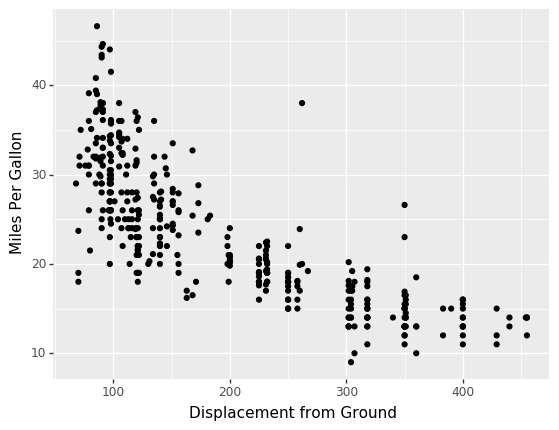

<ggplot: (-9223371904786837232)>

In [3]:
(
    pn.ggplot(automobile_df) +
    pn.geom_point(pn.aes(x = 'displacement', y= 'mpg')) + 
    pn.xlab('Displacement from Ground') + 
    pn.ylab('Miles Per Gallon')
)

Let's try to fit our own line to the dataset.

What is happening to the mileage as the engine size is increasing?

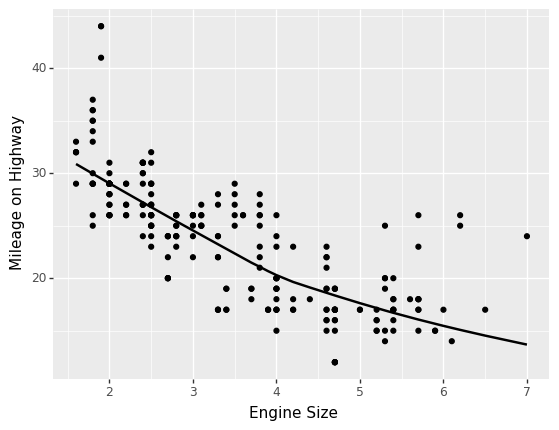

<ggplot: (-9223371904786764580)>

In [4]:
(
    pn.ggplot(data=mpg, mapping=pn.aes(x="displ", y="hwy")) +
    pn.geom_point() + 
    pn.stat_smooth(se=False, method= 'lowess') +
    pn.xlab("Engine Size") + 
    pn.ylab("Mileage on Highway")
)

Now a Data Scientist generally spends a majority of their time on "tidying" up the data.
This involves dealing with missing data, corrupted data, munging data from different
sources into a single table and so on. Since I'm not focusing on that in today's talk,
I'm going to use this dataset that I've already preprocessed for the rest of the talk.

What is the structure of our code going to look like?

In [6]:
class ModelData(typing.NamedTuple):
    inputs: np.ndarray
    targets: np.ndarray
    

class DataSplits(typing.NamedTuple):
    train: ModelData
    test: ModelData
    
    
# Generate training and testing data
class TrainValSplitFn(Protocol):
    """ This is the API that the function for generating the training and validation
    splits
    
    """
    def __call__(self, data: ModelData) -> DataSplits:
        raise NotImplementedError

# Any data transformation
class TransformDataFn(Protocol):
    """ Any data transformation we do will be using a function with this API. 
    
    Such a data transformation function would just take in the input data (X) and return
    a transformed copy of the data. 
    
    NOTE: Do NOT modify the input data. Create a copy and modify it instead. In general,
    it's better to keep our functions devoid of any side effects. Modifying the inputs
    of a function, modifying the file system etc are examples of side effects. Functions
    which do not have any side effects are called "pure" functions.
    """
    def __call__(self, data: ModelData) -> ModelData:
        raise NotImplementedError

# Fit model
class FitModelFn(Protocol):
    """ All our models will follow this API.
    
    Our models are going to be functions that take in the train and test data frames,
    and return a learned LinearModel.
    """
    def __call__(self, data: ModelData) -> LinearModel:
        raise NotImplementedError


# Generate validation metrics
class ValidationMetrics(typing.NamedTuple):
    """ The set of metrics that we're interested in when comparing different models. """
    test_score: float
    training_score: float
    

class ValidationMetricsFn(Protocol):
    """ Function that generates the metrics for validating the model performance. """
    def __call__(self, model: LinearModel, data: DataSplits) -> ValidationMetrics:
        raise NotImplementedError
    
    
class PlotFn(Protocol):
    """ Function that does any required plotting for us. """
    def __call__(self, model: LinearModel, data: DataSplits) -> typing.Any:
        raise NotImplementedError
    
    

Let's generate the train test splits for our data

In [7]:
def ensure_2d(data: ModelData) -> ModelData:
    """ If the data has less than 2 dims, expand it to at least 2D. """
    return ModelData(
        inputs=data.inputs.reshape(-1, 1), targets=data.inputs.reshape(-1, 1)
    )


def standard_scaling_data_transform(data: ModelData) -> ModelData:
    """ """
    pre_processor = StandardScaler()
    return ModelData(
        inputs=pre_processor.fit_transform(data.inputs),
        targets=data.targets
    )


def dummy_data_transform(data: ModelData) -> ModelData:
    """ Returns data as is. Useful for passing in as a default data transform when you
    don't want to do any data transformation. 
    
    """
    return data


def dummy_plot(model: LinearModel, data: ModelData) -> None:
    pass
    
    
def simple_validation(model: LinearModel, data: DataSplits) -> ValidationMetrics:
    predictions = model.predict(data.test.inputs)
    training_score = model.score(data.train.inputs, data.train.targets)
    test_score = r2_score(data.test.targets, predictions)
    return ValidationMetrics(test_score=test_score, training_score=training_score)


def create_data_splits(
    data_frame: pd.DataFrame,
    input_columns: typing.List[str],
    target_column: str,
    test_size: float = 0.2,
    data_transform: TransformDataFn = dummy_data_transform,
) -> DataSplits:
    model_data = ModelData(
        inputs=data_frame[input_columns].values,
        targets=data_frame[target_column].values,
    )
    transformed_data = data_transform(model_data)
    x_train, x_test, y_train, y_test = train_test_split(
        transformed_data.inputs, transformed_data.targets, test_size=test_size
    )
    return DataSplits(
        train=ModelData(x_train, y_train), test=ModelData(x_test, y_test)
    )

Now that we've defined the structure of helper functions, let's use them to write the
function that is going to go through the transformation, training and validation loop
and report the results for us. We can then use this function for every new model that
we want to test.

In [8]:
def try_model(
    model_trainer: FitModelFn,
    data_frame: pd.DataFrame,
    input_columns: typing.List[str],
    target_column: str,
    validation_fn: ValidationMetricsFn,
    plot_fn: PlotFn = dummy_plot,
    test_size: float = 0.2,
    data_transform: TransformDataFn = dummy_data_transform,
):
    """  """
    model_data = ModelData(
        inputs=data_frame[input_columns].values,
        targets=data_frame[target_column].values,
    )
    transformed_data = data_transform(model_data)
    x_train, x_test, y_train, y_test = train_test_split(
        transformed_data.inputs, transformed_data.targets, test_size=test_size
    )
    data = DataSplits(
        train=ModelData(x_train, y_train), test=ModelData(x_test, y_test)
    )
    model = model_trainer(data.train)
    print(plot_fn(model, data))
    return validation_fn(model, data)

And let's throw in some plotting functions

In [20]:
def plot_predictions_vs_targets(model: LinearModel, data: DataSplits) -> pn.ggplot:
    data_frame = pd.DataFrame.from_dict(
        dict(
            targets=data.test.targets.flat,
            predictions=model.predict(data.test.inputs).flat
        )
    )
    data_frame['obs_nbr'] = np.arange(len(data_frame))+1
    data_frame = pd.melt(data_frame,id_vars = 'obs_nbr', value_vars = ['targets','predictions']).reset_index()
    return (
        pn.ggplot(data=data_frame) +
        pn.geom_line(mapping=pn.aes(x = 'obs_nbr', y='value', color = 'variable')) + 
        pn.xlab('Observations')+
        pn.ylab('Miles per Gallon') + 
        pn.ggtitle('Predicted vs Actual')
    )

Let's compare some models now!!!

In [14]:
split_data = create_data_splits(
    data_frame=automobile_df,
    input_columns=["weight"],
    target_column="mpg",
)

In [15]:
def linear_reg(data: ModelData) -> LinearRegression:
    x_train, y_train = data
    model = LinearRegression(normalize=True)
    model.fit(x_train,y_train)
    
    return model

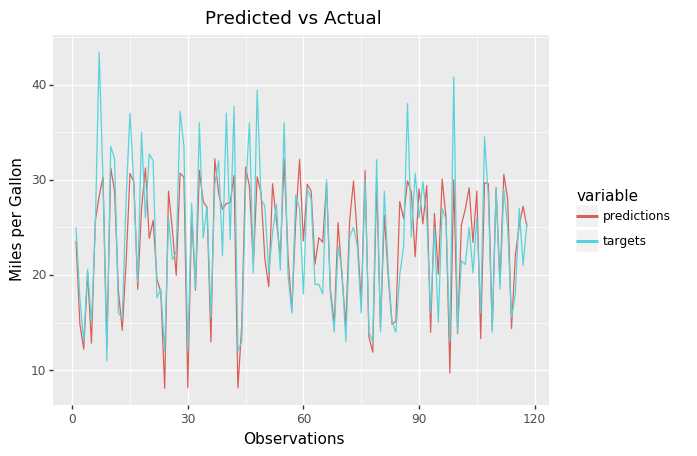

<ggplot: (-9223371904916357924)>
ValidationMetrics(test_score=0.7048452484512957, training_score=0.6868153691443427)


In [17]:
linear_regression_metrics = try_model(
    model_trainer=linear_reg,
    data_frame=automobile_df,
    input_columns=["weight"],
    target_column="mpg",
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
    test_size=0.3,
)
result_dict = {}
result_dict['Simple Linear Regression'] = linear_regression_metrics
print(linear_regression_metrics)

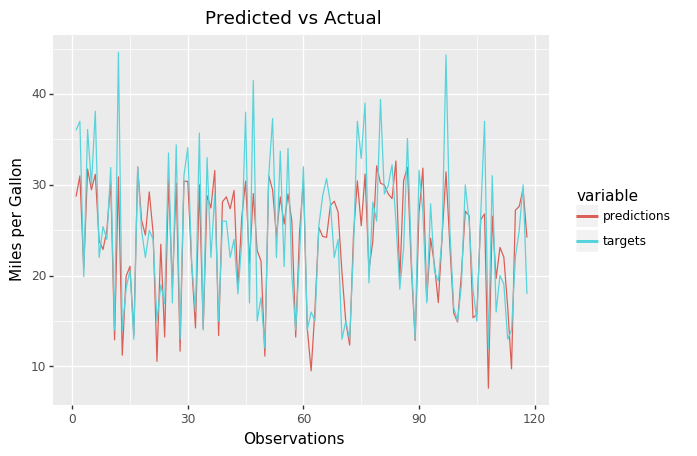

<ggplot: (-9223371904916149924)>
ValidationMetrics(test_score=0.6996437639181681, training_score=0.703297028060926)


In [21]:
multiple_regression_metrics_all_vars = try_model(
    model_trainer=linear_reg,
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column='mpg',
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
    test_size=0.3,
)
result_dict['Multiple Regression using all available variables'] = multiple_regression_metrics_all_vars
print(multiple_regression_metrics_all_vars)

In [22]:
result_dict

{'Simple Linear Regression': ValidationMetrics(test_score=0.7048452484512957, training_score=0.6868153691443427),
 'Multiple Regression using all available variables': ValidationMetrics(test_score=0.6996437639181681, training_score=0.703297028060926)}

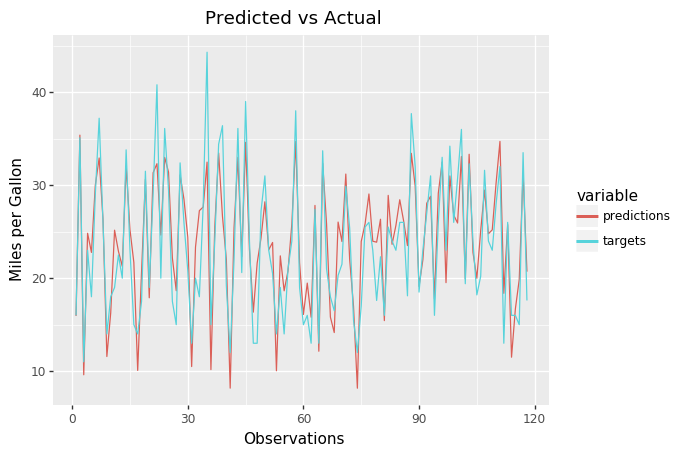

<ggplot: (-9223371904915866376)>


{'Simple Linear Regression': ValidationMetrics(test_score=0.7048452484512957, training_score=0.6868153691443427),
 'Multiple Regression using all available variables': ValidationMetrics(test_score=0.6996437639181681, training_score=0.703297028060926),
 'Parsimonious Liear Regression': ValidationMetrics(test_score=0.7780509701547556, training_score=0.8187130894305543)}

In [24]:
parsimonious_regression_metrics = try_model(
    model_trainer=linear_reg,
    data_frame=automobile_df,
    input_columns='weight Age'.split(),
    target_column='mpg',
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
    test_size=0.3,
)
result_dict['Parsimonious Liear Regression'] = parsimonious_regression_metrics
result_dict

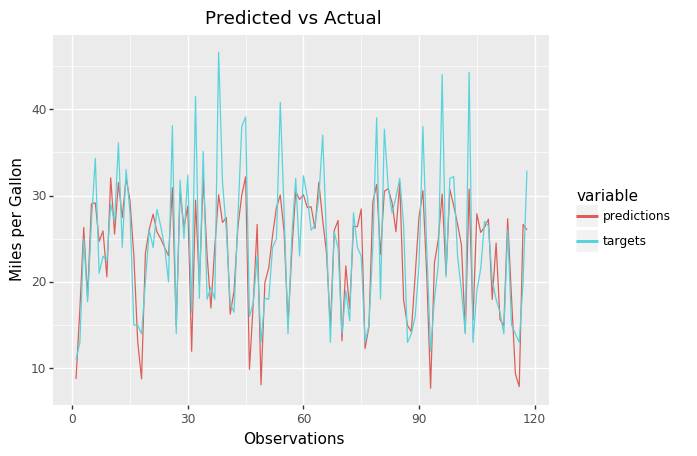

<ggplot: (-9223371904786608960)>


{'Simple Linear Regression': ValidationMetrics(test_score=0.7048452484512957, training_score=0.6868153691443427),
 'Multiple Regression using all available variables': ValidationMetrics(test_score=0.6996437639181681, training_score=0.703297028060926),
 'Parsimonious Liear Regression': ValidationMetrics(test_score=0.7780509701547556, training_score=0.8187130894305543),
 'Lasso Regression': ValidationMetrics(test_score=0.6725766443760444, training_score=0.7214361223866695)}

In [28]:
def lasso_reg(
    data : ModelData,
    alpha = 0.5,
) -> Lasso:
    x_train, y_train = data
    model = Lasso(alpha = alpha)
    model.fit(x_train, y_train)
    
    return model  

lasso_regression_metrics = try_model(
    model_trainer=lasso_reg,
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column='mpg',
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
    test_size=0.3,
)
result_dict['Lasso Regression'] = lasso_regression_metrics
result_dict

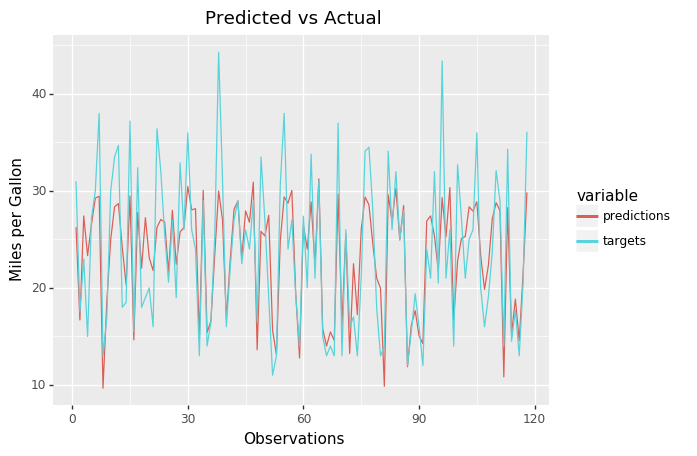

<ggplot: (-9223371904915842692)>


{'Simple Linear Regression': ValidationMetrics(test_score=0.7048452484512957, training_score=0.6868153691443427),
 'Multiple Regression using all available variables': ValidationMetrics(test_score=0.6996437639181681, training_score=0.703297028060926),
 'Parsimonious Liear Regression': ValidationMetrics(test_score=0.7780509701547556, training_score=0.8187130894305543),
 'Lasso Regression': ValidationMetrics(test_score=0.6725766443760444, training_score=0.7214361223866695),
 'Ridge Regression': ValidationMetrics(test_score=0.6805058221787348, training_score=0.685826240310172)}

In [30]:
def ridge_reg(
    data: ModelData,
    alpha=0.5,
    normalize = True,
) -> Ridge:
    x_train, y_train = data
    model = Ridge(alpha = alpha, normalize=normalize)
    model.fit(x_train, y_train)
    
    return model

ridge_regression_metrics = try_model(
    model_trainer=ridge_reg,
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column='mpg',
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
    test_size=0.3,
)

result_dict['Ridge Regression'] = ridge_regression_metrics
result_dict

c:\users\mxg4153\.conda\envs\presentation\lib\site-packages\ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
c:\users\mxg4153\.conda\envs\presentation\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
c:\users\mxg4153\.conda\envs\presentation\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2731.5633173230426, tolerance: 1.8399343642172532
  positive)


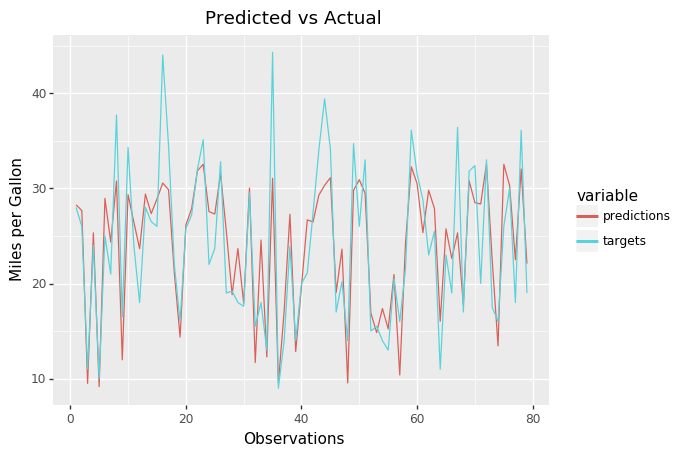

<ggplot: (-9223371904916236012)>


{'Simple Linear Regression': ValidationMetrics(test_score=0.7048452484512957, training_score=0.6868153691443427),
 'Multiple Regression using all available variables': ValidationMetrics(test_score=0.6996437639181681, training_score=0.703297028060926),
 'Parsimonious Liear Regression': ValidationMetrics(test_score=0.7780509701547556, training_score=0.8187130894305543),
 'Lasso Regression': ValidationMetrics(test_score=0.6725766443760444, training_score=0.7214361223866695),
 'Ridge Regression': ValidationMetrics(test_score=0.6805058221787348, training_score=0.685826240310172),
 'Elastic Net Regression': ValidationMetrics(test_score=0.7177336738190238, training_score=0.7030803521640746)}

In [32]:
def elastic_net_reg(
    data: ModelData,
    alpha = 0.3,
    l1_ratio = 0.5,
    max_iter = 100000,
    warm_start = True
) -> ElasticNet:
    x_train, y_train = data
    model = ElasticNet(alpha = alpha,l1_ratio = l1_ratio, max_iter = max_iter, warm_start = warm_start)
    model.fit(x_train,y_train)
    
    return model


elastic_net_regression_metrics = try_model(
    model_trainer=partial(elastic_net_reg, alpha=0, l1_ratio=0.5),
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column="mpg",
    validation_fn=simple_validation,
    plot_fn=plot_predictions_vs_targets,
)

result_dict['Elastic Net Regression'] = elastic_net_regression_metrics
result_dict

In [40]:
def linear_svr(data = ModelData, kernel = 'linear', C=0.3, epsilon=0.05) -> SVR:
    x_train, y_train = data
    model = SVR(kernel=kernel, C=C, epsilon=epsilon)
    model.fit(x_train, y_train)
    
    return model

linear_svr_metrics = try_model(
    model_trainer=linear_svr,
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column="mpg",
    validation_fn=simple_validation,
    plot_fn=dummy_plot,
)

result_dict['Linear Support Vector Regression'] = linear_svr_metrics

def knn_reg(data = ModelData, n_neighbors = 10) -> KNeighborsRegressor:
    x_train, y_train = data
    model = KNeighborsRegressor(n_neighbors=n_neighbors)
    model.fit(x_train, y_train)
    
    return model

knn_metrics = try_model(
    model_trainer=knn_reg,
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column="mpg",
    validation_fn=simple_validation,
    plot_fn=dummy_plot,
)

result_dict['K Nearest Neighbors Regression'] = knn_metrics

def sgd_reg(data = ModelData, max_iter = 10000, tol = 1e-3, l1_ratio = 0.907, alpha = 0.4755) -> SGDRegressor:
    x_train, y_train = data
    model = SGDRegressor(max_iter=max_iter, tol=tol, l1_ratio=l1_ratio, alpha=alpha)
    model.fit(x_train, y_train)
    
    return model

sgd_metrics = try_model(
    model_trainer=sgd_reg,
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column="mpg",
    validation_fn=simple_validation,
    plot_fn=dummy_plot,
)

result_dict['Stochastic Gradient Regression'] = sgd_metrics

def dtreg(data = ModelData, max_depth=2) -> DecisionTreeRegressor:
    x_train, y_train = data
    model = DecisionTreeRegressor(max_depth=max_depth)
    model.fit(x_train, y_train)
    
    return model

dtreg_metrics = try_model(
    model_trainer=dtreg,
    data_frame=automobile_df,
    input_columns='weight displacement horsepower acceleration'.split(),
    target_column="mpg",
    validation_fn=simple_validation,
    plot_fn=dummy_plot,
)

result_dict['Decision Tree Regression'] = dtreg_metrics

None
None
None
None


In [44]:
pd.DataFrame.from_dict(result_dict, orient='index').to_csv('tests/Model_simple_validation_scores.csv')